<a href="https://colab.research.google.com/github/WiltonSaturnino200890/MachineLearningPythonGans/blob/main/redeneuralgenerativa_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rede Neurais com GANS

Nosso conjunto de dados

In [24]:
import torch
import matplotlib.pyplot as plt
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
from IPython import display

In [25]:
imgsize = 28
batch_size = 128
DATA_DIR = '/content/drive/MyDrive/LivePGGANS'
IMG_DIR = os.path.join(DATA_DIR, 'results')

In [26]:
fashiontransform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
     ]
)


fashiondata = datasets.FashionMNIST(DATA_DIR, transform=fashiontransform, download=True)
dataloader = DataLoader(fashiondata, batch_size=batch_size, shuffle=True)

In [27]:
img, label = fashiondata[0]

In [28]:
def lookat_dataset(dataset, pilimg=False):
  figure = plt.figure(figsize=(16, 4))
  rows, cols = 2, 8
  for i in range(1, 17):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    if pilimg:
      plt.imshow(img)
    else:
      img = (img.squeeze()*0.5) + 0.5
      if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
      else:
        plt.imshow(img.permute(1,2,0))
  plt.show()

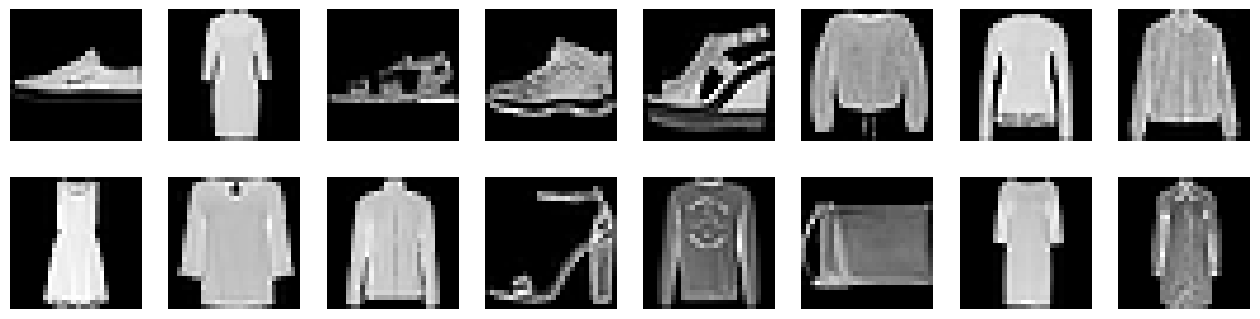

In [29]:

lookat_dataset(fashiondata)

In [30]:
class Generator(nn.Module):
  def __init__(self, n_in, n_out):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Linear(n_in, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 1024),
        nn.ReLU(),
        nn.Linear(1024, n_out),
        nn.Tanh()

    )

  def forward(self, z):
    return self.layers(z)

class Discriminator(nn.Module):

    def __init__(self, n_in):
      super().__init__()
      n_out = 1

      self.layers = nn.Sequential(
          nn.Linear(n_in, 1024),
          nn.LeakyReLU(0.2),

          nn.Linear(1024, 512),
          nn.LeakyReLU(0.2),

          nn.Linear(512, 256),
          nn.LeakyReLU(0.2),

          torch.nn.Linear(256, n_out),
          torch.nn.Sigmoid()
      )

    def forward(self, x):
      return self.layers(x)


In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print = (f'Rodando na {device}')

In [32]:
noise_dim = 100
generator = Generator(noise_dim, imgsize*imgsize).to(device)
discriminator = Discriminator(imgsize*imgsize).to(device)

In [33]:
def images_to_vectors(images):
  return images.view(images.size(0), imgsize*imgsize)

def vectors_to_images(vectors, nc=1):
  return vectors.view(vectors.size(0), nc, imgsize, imgsize)

def noise(size, dim=noise_dim, device=device):
  return torch.randn(size, dim).to(device)

#Visualization
def log_images(test_images, savepath=None):
  figure = plt.figure(figsize=(8, 8))
  figure.subplots_adjust(wspace=-0.08, hspace=0.01)
  row, cols = len(test_images)//4,4
  for i, img in enumerate(test_images):
    figure.add_subplot(row, cols, i+1)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')

  if savepath is not None:
    figure.savefig(savepath)
  plt.show()


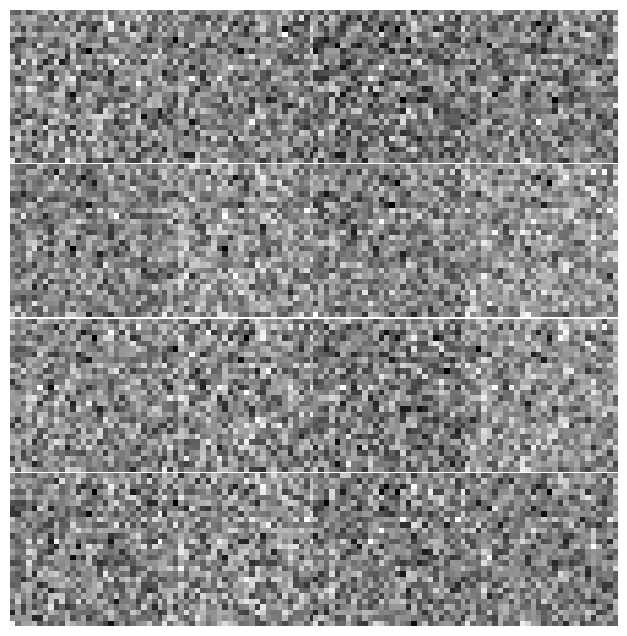

In [34]:
num_test_samples = 16
torch.manual_seed(7777)
test_noise = noise(num_test_samples, noise_dim)
imagepath = os.path.join(IMG_DIR, f'{0}.jpg')
log_images(
    vectors_to_images(
        generator(test_noise)).cpu().detach().numpy(),
        imagepath
)

Treinamento

In [35]:
def real_data_target(size, device=device):
  return torch.ones(size, 1).to(device)

def fake_data_target(size, device=device):
  return torch.zeros(size, 1).to(device)

In [36]:
lr = 0.0002
g_optimizer = optim.Adam(generator.parameters(), lr=lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
loss = nn.BCELoss()


In [37]:
def train_discriminator(optimizer, real_data, fake_data):

  optimizer.zero_grad()

  pred_real = discriminator(real_data)
  # só a parte referente aos dados reais
  error_real = loss(pred_real, real_data_target(real_data.size(0)))
  error_real.backward()

  pred_fake = discriminator(fake_data)
  error_fake = loss(
      pred_fake, fake_data_target(fake_data.size(0))
  )
  error_fake.backward()

  optimizer.step()

  return error_real + error_fake, pred_real, pred_fake

def train_generator(optimizer, fake_data):
    optimizer.zero_grad()
    pred = discriminator(fake_data)
    error = loss(pred, real_data_target(pred.size(0)))
    error.backward()
    optimizer.step()

    return error


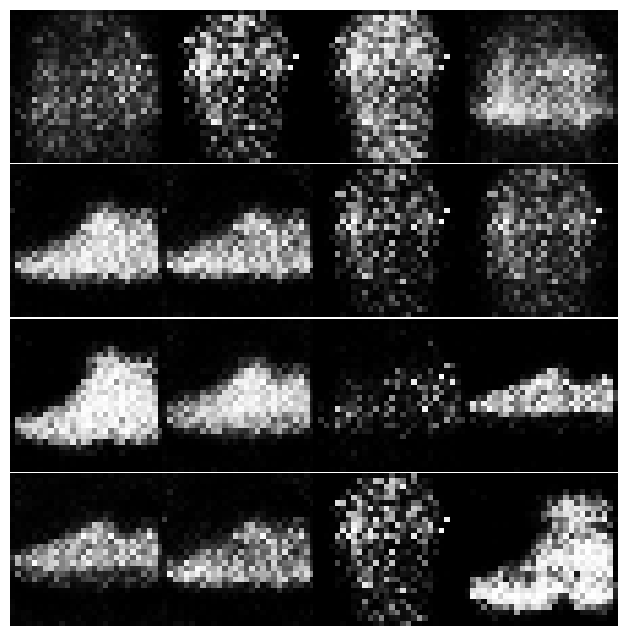

TypeError: 'str' object is not callable

In [38]:
num_epochs = 20
G_losses = []
D_losses = []
for epoch in range(1, num_epochs):
  for realbatch, _ in dataloader:
      real_data = images_to_vectors(realbatch).to(device)

      fake_data = generator(
          noise(real_data.size(0))
      )

      d_error, dpred_real, dpred_fake= (
          train_discriminator(d_optimizer, real_data, fake_data))

      fake_data = generator(noise(real_data.size(0)))
      g_error= train_generator(g_optimizer, fake_data)

      # Show generated imagens
imagepath = os.path.join(IMG_DIR, f'{epoch+1}.jpg')
test_images = vectors_to_images(generator(test_noise)).cpu().detach().numpy()
log_images(test_images, imagepath)

      # Display status Logs
G_losses.append(g_error)
D_losses.append(d_error)
print(f"Epoch: {epoch}/{num_epochs} Losses:")
print(f'Discriminator: {d_error: .4f}; Generator: {g_error: .4f}')
print(f'D(x): {dpred_real.mean(): .4f}; D(G(z)):{dpred_fake.mean(): .4f}')


Visualizar os resultados